## Starting, using and ending a DIDComm connection
This tutorial shows how Alice can invite Bob to start a connection, send and receive encrypted messages using an https transport, and end the relationship.

The code relies on [DIDComm Python](https://github.com/sicpa-dlab/didcomm-python) and [Peerdid Python](https://github.com/sicpa-dlab/peer-did-python) libraries from [SICPA](https://www.sicpa.com).

### Step 1: Imports
First, we need to import all required functions, clases and types from `didcomm` and `peerdid` libraries.

In [47]:
import json
import base64
import qrcode
import requests
import matplotlib.pyplot as plt
from typing import Optional, List
from didcomm.common.types import DID, VerificationMethodType, VerificationMaterial, VerificationMaterialFormat
from didcomm.did_doc.did_doc import DIDDoc, VerificationMethod, DIDCommService
from didcomm.did_doc.did_resolver import DIDResolver
from didcomm.message import Message, FromPrior
from didcomm.secrets.secrets_resolver_demo import SecretsResolverDemo
from didcomm.unpack import unpack, UnpackResult
from didcomm.common.resolvers import ResolversConfig
from didcomm.pack_encrypted import pack_encrypted, PackEncryptedConfig, PackEncryptedResult
from peerdid.core.did_doc_types import DIDCommServicePeerDID
from didcomm.secrets.secrets_util import generate_x25519_keys_as_jwk_dict, generate_ed25519_keys_as_jwk_dict, jwk_to_secret
from peerdid import peer_did
from peerdid.did_doc import DIDDocPeerDID
from peerdid.types import VerificationMaterialAuthentication, VerificationMethodTypeAuthentication, VerificationMaterialAgreement, VerificationMethodTypeAgreement, VerificationMaterialFormatPeerDID

### Step 2: Helpers
In this step we add three helper functionalities:

1. **Secret resolver**

This sample code needs a storage to keep the generated key pair secrets. It will then be referenced by the library as a `secrets_resolver`. We can instantiate it as follows:

In [2]:
secrets_resolver = SecretsResolverDemo()

Note that the `SecretsResolverDemo` simply stores the keys in a text file named `secrets.json`. As you've just realized, this secret storage is anything but secure. Keep in mind that securing keys is of utmost importance for a self-sovereign identity; never use it in production.

2. **DID Resolver**

The following class is needed by the library to resolve the DID Peer into a DID Document and put it in the format required by the library:

In [3]:
class DIDResolverPeerDID(DIDResolver):
    async def resolve(self, did: DID) -> DIDDoc:
        did_doc_json = peer_did.resolve_peer_did(did, format = VerificationMaterialFormatPeerDID.JWK)
        did_doc = DIDDocPeerDID.from_json(did_doc_json)

        return DIDDoc(
            did=did_doc.did,
            key_agreement_kids = did_doc.agreement_kids,
            authentication_kids = did_doc.auth_kids,
            verification_methods = [
                VerificationMethod(
                    id = m.id,
                    type = VerificationMethodType.JSON_WEB_KEY_2020,
                    controller = m.controller,
                    verification_material = VerificationMaterial(
                        format = VerificationMaterialFormat.JWK,
                        value = json.dumps(m.ver_material.value)
                    )
                )
                for m in did_doc.authentication + did_doc.key_agreement
            ],
            didcomm_services = [
                DIDCommService(
                    id = s.id,
                    service_endpoint = s.service_endpoint,
                    routing_keys = s.routing_keys,
                    accept = s.accept
                )
                for s in did_doc.service
                if isinstance(s, DIDCommServicePeerDID)
            ] if did_doc.service else []
        )

3. **DID Peer creation**

We add the following function to simplify key generation, key storage, and the creation of a DID Peer:

In [4]:
async def create_peer_did(self,
                        auth_keys_count: int = 1,
                        agreement_keys_count: int = 1,
                        service_endpoint: Optional[str] = None,
                        service_routing_keys: Optional[List[str]] = None
                        ) -> str:
        # 1. generate keys in JWK format
        agreem_keys = [generate_x25519_keys_as_jwk_dict() for _ in range(agreement_keys_count)]
        auth_keys = [generate_ed25519_keys_as_jwk_dict() for _ in range(auth_keys_count)]

        # 2. prepare the keys for peer DID lib
        agreem_keys_peer_did = [
            VerificationMaterialAgreement(
                type=VerificationMethodTypeAgreement.JSON_WEB_KEY_2020,
                format=VerificationMaterialFormatPeerDID.JWK,
                value=k[1],
            )
            for k in agreem_keys
        ]
        auth_keys_peer_did = [
            VerificationMaterialAuthentication(
                type=VerificationMethodTypeAuthentication.JSON_WEB_KEY_2020,
                format=VerificationMaterialFormatPeerDID.JWK,
                value=k[1],
            )
            for k in auth_keys
        ]

        # 3. generate service
        service = None
        if service_endpoint:
            service = json.dumps(
                DIDCommServicePeerDID(
                    id="new-id",
                    service_endpoint=service_endpoint, routing_keys=service_routing_keys,
                    accept=["didcomm/v2"]
                ).to_dict()
            )

        # 4. call peer DID lib
        # if we have just one key (auth), then use numalg0 algorithm
        # otherwise use numalg2 algorithm
        if len(auth_keys_peer_did) == 1 and not agreem_keys_peer_did and not service:
            did = peer_did.create_peer_did_numalgo_0(auth_keys_peer_did[0])
        else:
            did = peer_did.create_peer_did_numalgo_2(
                encryption_keys=agreem_keys_peer_did,
                signing_keys=auth_keys_peer_did,
                service=service,
            )

        # 5. set KIDs as in DID DOC for secrets and store the secret in the secrets resolver
        did_doc = DIDDocPeerDID.from_json(peer_did.resolve_peer_did(did))
        for auth_key, kid in zip(auth_keys, did_doc.auth_kids):
            private_key = auth_key[0]
            private_key["kid"] = kid
            await secrets_resolver.add_key(jwk_to_secret(private_key))

        for agreem_key, kid in zip(agreem_keys, did_doc.agreement_kids):
            private_key = agreem_key[0]
            private_key["kid"] = kid
            await secrets_resolver.add_key(jwk_to_secret(private_key))

        return did


### Step 3: Out of Band Invitation
Using our `create_peer_did` helper function, Alice will create a DID Peer to be shared in the OOB invitation. Since an OOB invitation is unencrypted and may be observed by another party, this DID should not be considered private and must be rotated later for privacy.
Alice DID also contains a `service` part that tells Bob the `serviceEndpoint` where she accepts messages. In this case Alice provides an `https` endpoint. For other cases additional [Routing](https://identity.foundation/didcomm-messaging/spec/#routing-protocol-20) may be required.

In [5]:
alice_did_oob = await create_peer_did(1, 1, service_endpoint="https://www.example.com/alice")
print("Alice's OOB DID:", alice_did_oob)


Alice's OOB DID: did:peer:2.Ez6LSh6rmgWhAsvyYRo5mnKTuZtSkMb9keidqDGUygrPD9kgK.Vz6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJxQk8cL98hoj.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9hbGljZSIsImEiOlsiZGlkY29tbS92MiJdfQ


Remember that while creating this DID, our helper function also stores the private keys in the `secrets_resolver`. In a real implementation, Alice will have her own secure store in her own wallet, and Bob will have a separated secure store in his own wallet.
Also, those Peer DIDs can be resolved into DID documents that contain the *Authentication*, *Agreement* public keys, and the *Service* details.

With this DID Peer, Alice can create an Out Of Band invitation message as follows:

In [48]:
oob_mesage = {
  "type": "https://didcomm.org/out-of-band/2.0/invitation",
  "id": "unique-id-24160d23ed1d",
  "from": alice_did_oob,
  "body": {
    "goal_code": "connect",
    "goal": "Start relationship",
    "accept": [
      "didcomm/v2",
      "didcomm/aip2;env=rfc587"
    ],
  }  
}

You can see that the `type` of the message was declared as "https://didcomm.org/out-of-band/2.0/invitation" and Alice OOB DID was included in the `from` header. Also, remember that the unique `id` declared in the message must be used in the parent thread ID `pthid` in Bob's following response.

The message has to be whitespaced removed and encoded using URL Base 64.

In [7]:
plaintext_ws_removed = json.dumps(oob_mesage).replace(" ", "")
encoded_plaintextjwm = base64.urlsafe_b64encode(plaintext_ws_removed.encode("utf-8"))
encoded_text = str(encoded_plaintextjwm, "utf-8").replace("=","")

Finally, we put the encoded message in a URL that can be emailed to Bob:

In [8]:
oob_url = "https://example.com/path?_oob="+encoded_text
print(oob_url)

https://example.com/path?_oob=eyJ0eXBlIjoiaHR0cHM6Ly9kaWRjb21tLm9yZy9vdXQtb2YtYmFuZC8yLjAvaW52aXRhdGlvbiIsImlkIjoidW5pcXVlLWlkLTI0MTYwZDIzZWQxZCIsImZyb20iOiJkaWQ6cGVlcjoyLkV6NkxTaDZybWdXaEFzdnlZUm81bW5LVHVadFNrTWI5a2VpZHFER1V5Z3JQRDlrZ0suVno2TWtzcXRkWHVUYXI0Z2pQVE1HNnRFZVBMOWRGSEJjNnM3bUp4UWs4Y0w5OGhvai5TZXlKcFpDSTZJbTVsZHkxcFpDSXNJblFpT2lKa2JTSXNJbk1pT2lKb2RIUndjem92TDNkM2R5NWxlR0Z0Y0d4bExtTnZiUzloYkdsalpTSXNJbUVpT2xzaVpHbGtZMjl0YlM5Mk1pSmRmUSIsImJvZHkiOnsiZ29hbF9jb2RlIjoiY29ubmVjdCIsImdvYWwiOiJFc3RhYmxpc2hjb25uZWN0aW9uIiwiYWNjZXB0IjpbImRpZGNvbW0vdjIiLCJkaWRjb21tL2FpcDI7ZW52PXJmYzU4NyJdfX0


Other common option to share the OOB message is by creating a QR code that Bob can scan:

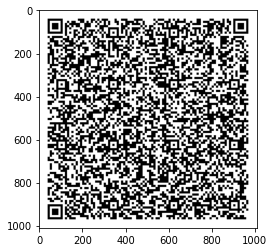

In [9]:
image = qrcode.make(oob_url)
plt.imshow(image , cmap = 'gray')

### Step 4: Receiving the OOB message
Once Bob receives the email or scan the QR code, he can easily decod it and read Alice's message:

In [52]:
received_msg_encoded = oob_url.split("=")[1]
received_msg_decoded = json.loads(str(base64.urlsafe_b64decode(received_msg_encoded + "=="), "utf-8"))
print(received_msg_decoded)

{'type': 'https://didcomm.org/out-of-band/2.0/invitation', 'id': 'unique-id-24160d23ed1d', 'from': 'did:peer:2.Ez6LSh6rmgWhAsvyYRo5mnKTuZtSkMb9keidqDGUygrPD9kgK.Vz6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJxQk8cL98hoj.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9hbGljZSIsImEiOlsiZGlkY29tbS92MiJdfQ', 'body': {'goal_code': 'connect', 'goal': 'Establishconnection', 'accept': ['didcomm/v2', 'didcomm/aip2;env=rfc587']}}


After Bob checks the invitation, he is able to prepare a response back. Since Bob has not established a connection with Alice before, he needs to create a DID peer to be used in all communications with Alice. This DID Peer will be dedicated to Alice and only Alice. If Bob needs to comunicate with someone else, he should create a new DID Peer.

In [53]:
bob_did = await create_peer_did(1,1, service_endpoint="https://www.example.com/bob")
print("Bob's DID:", bob_did)

Bob's DID: did:peer:2.Ez6LSfHCNnrXfs6mPio69GbvoL6szGxCXcL3tf8kLDQDYsncm.Vz6MkiDnmWvdnKoFrn7fDfXVykbRmW7MuEyMp1ZcnZu1KvUZL.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9ib2IiLCJhIjpbImRpZGNvbW0vdjIiXX0


Bob's response will depends on the `goal` code of the invitation received. Here is a response message as an example:

In [12]:
bob_response_message = Message(
    body = {"msg": "Hi Alice"},
    id = "unique-id-263e24a422e",
    pthid = received_msg_decoded["id"],
    type = "my-protocol/1.0",
    frm = bob_did,
    to = [received_msg_decoded["from"]]
)

Note that the message includes an `id` that is mandatory and has to be unique to Bob, but also includes the parent thread ID `pthid` matching Alice's message `id`.

Also includes a `type`, also mandatory, that points to the protocol identifier in conformance with the `goal` of the invitation. The `body` contains the actual message in a structured way associated by our `my-protocol/1.0`. Attributes `from` and `to` are optional. Beware that in the code above the property `from` was replaced by `frm` due to a conflict of reserved words in Python; the conversion to the correct property (`from`) is handled internally by the library.

The final encrypted and packed message can be generated with this code:

In [26]:
bob_packed_msg = await pack_encrypted(
    resolvers_config = ResolversConfig(
        secrets_resolver = secrets_resolver,
        did_resolver = DIDResolverPeerDID()
    ),
    message = bob_response_message,
    frm = bob_did,
    to = alice_did_oob,
    sign_frm = None,
    pack_config = PackEncryptedConfig(protect_sender_id=False)
)

### Step 5: Sending the message to Alice

From the received message, Bob can get and resolve Alice's DID into a DID Document. He can use a [Universal Resolver](https://dev.uniresolver.io) or just our helper class as we use in the following lines:

In [14]:
alice_did_doc = json.loads(peer_did.resolve_peer_did(received_msg_decoded["from"]))
print(alice_did_doc)

{'id': 'did:peer:2.Ez6LSh6rmgWhAsvyYRo5mnKTuZtSkMb9keidqDGUygrPD9kgK.Vz6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJxQk8cL98hoj.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9hbGljZSIsImEiOlsiZGlkY29tbS92MiJdfQ', 'authentication': [{'id': 'did:peer:2.Ez6LSh6rmgWhAsvyYRo5mnKTuZtSkMb9keidqDGUygrPD9kgK.Vz6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJxQk8cL98hoj.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9hbGljZSIsImEiOlsiZGlkY29tbS92MiJdfQ#6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJxQk8cL98hoj', 'type': 'Ed25519VerificationKey2020', 'controller': 'did:peer:2.Ez6LSh6rmgWhAsvyYRo5mnKTuZtSkMb9keidqDGUygrPD9kgK.Vz6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJxQk8cL98hoj.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9hbGljZSIsImEiOlsiZGlkY29tbS92MiJdfQ', 'publicKeyMultibase': 'z6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJxQk8cL98hoj'}], 'keyAgreement': [{'id': 'did:peer:2.Ez6LSh6rmgWhAsvyYRo5mnKTuZtSkMb9keidqDGUygrPD9kgK.Vz6MksqtdXuTar4gjPTMG6tEePL9dFHBc6s7mJx

From the DID Document, Bob can understand how Alice is expecting to receive messages. In this case, he gets Alice's endpoint:

In [15]:
alice_endpoint = alice_did_doc["service"][0]["serviceEndpoint"]
print(alice_endpoint)

https://www.example.com/alice


Using an `https` [transport](base64) Bob can simply `POST` the message to the endpoint with the message in the `body` and the media type header set to `application/didcomm-encrypted+json`.

In [16]:
headers = {"Content-Type": "application/didcomm-encrypted+json"}
resp = requests.post(alice_endpoint, headers=headers, data = bob_packed_msg.packed_msg)

In a real scenario, you will receive a success http response code in the range of 2XX such as a 202. This case will fail since it's not a real endpoint.

### Step 5: Alice responding back to Bob with a rotated DID
Alice has finally received a response back from Bob at her endpoint. The encrypted message is in the body of the POST request that can be unpacked and decrypted with the following code:

In [17]:
bob_unpack_msg = await unpack(
    resolvers_config=ResolversConfig(
        secrets_resolver=secrets_resolver,
        did_resolver=DIDResolverPeerDID()
    ),
    packed_msg=bob_packed_msg.packed_msg
)

Note that we also passed the resolver config as before.

Finally, Alice can see Bob's response message:

In [18]:
print(bob_unpack_msg.message.body["msg"])

Hi Alice


And also she can get Bob's DID Peer:

In [54]:
print(bob_unpack_msg.message.frm)

did:peer:2.Ez6LSmYH5Lttu3WFRCJuVyg8RXBD7ncvL5S93ojKUhan2Mhgs.Vz6MkmbHcPTycTGg23jsJK3diDnp4v5tt8hNnvbGWCzs3Trsv.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9ib2IiLCJhIjpbImRpZGNvbW0vdjIiXX0


and from Bob's DID, she can resolve the DID Document and get Bob's service endpoint:

In [55]:
bob_did_doc = json.loads(peer_did.resolve_peer_did(bob_unpack_msg.message.frm))
bob_endpoint = bob_did_doc["service"][0]["serviceEndpoint"]
print(bob_endpoint)

https://www.example.com/bob


Now Alice is able to respond back to Bob's. However, in order to keep DID Peers private between them, Alice must replace the DID used in the Out of Band message by a new one. That process is call [DID rotation](https://identity.foundation/didcomm-messaging/spec/#did-rotation).

A DID is rotated by sending a message to Bob including the `from_prior` header containng a JWT with the new DID in the `sub` and the prior DID in the `iss` fields.
First, she need to create the new DID Peer:

In [56]:
alice_did_new = await create_peer_did(1, 1, service_endpoint="https://www.example.com/alice")
print("Alice's NEW DID:", alice_did_new)

Alice's NEW DID: did:peer:2.Ez6LSnn1bdY7Zy5WLuXxMQWEpDb2o9L9g8fW9Z2NWdASTAAKd.Vz6MkqFwmMSecezdhHHGMQJPEpjkoSFNVBQRnQG15P1VbgJsN.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL3d3dy5leGFtcGxlLmNvbS9hbGljZSIsImEiOlsiZGlkY29tbS92MiJdfQ


Then, with the help of the library she can easily creat the `from_prior` header. More details on how to make the JWT can be found in Chapter 5.3 of [DIDComm Messaging Specification](https://identity.foundation/didcomm-messaging/spec/#did-rotation)

In [57]:
from_prior = FromPrior(iss=alice_did_oob, sub=alice_did_new)

In [58]:
alice_rotate_did_message = Message(
    body = {"msg": "I'm rotating my peer DID"},
    id = "unique-id-293e9a922e",
    type = "my-protocol/1.0",
    frm = alice_did_new,
    to = [bob_unpack_msg.message.frm],
    from_prior = from_prior
)

As in previous steps, Alice will encrypt and pack the message, and POST it to Bob's endpoint:

In [59]:
alice_packed_msg = await pack_encrypted(
    resolvers_config = ResolversConfig(
        secrets_resolver = secrets_resolver,
        did_resolver = DIDResolverPeerDID()
    ),
    message = alice_rotate_did_message,
    frm = alice_did_new,
    to = bob_unpack_msg.message.frm,
    sign_frm = None,
    pack_config = PackEncryptedConfig(protect_sender_id=False)
)

In [60]:
headers = {"Content-Type": "application/didcomm-encrypted+json"}
resp = requests.post(bob_endpoint, headers=headers, data = alice_packed_msg.packed_msg)

Bob will receive the message in his endpoint, unpack and decrypt, and get the new Alice's DID. He must store Alice's new DID and use it in subsequent communications.

### Step 6: What's next --> Protocols


Now Alice and Bob have a private way to communicate. This communication channel can be used whenever they need. Normally, messages passed back and forth will follow a protocol that can be understood by both. We won't cover protocols in this tutorial. You can read more about protocols in Chapter 9 of the [DIDComm Messaging specification](https://identity.foundation/didcomm-messaging/spec/#protocols)

### Step 7: Ending a relationship

Alice and Bob can use the channel forever. They know how to pass messages and even how to rotate a DID if needed. If for any reason, Alice (or Bob) need to end the relationship, she can simply send a message rotating the DID to nothing. That is achieved by ommiting the `sub` in the `from_prior` and sending the message without a `from` attribute of the message as it's shown below:

In [61]:
from_prior_end = FromPrior(iss=alice_did_new, sub=None)

In [62]:
alice_end_message = Message(
    body = {"msg": "I'm finishing this relationship :("},
    id = "unique-id-25359a955e",
    type = "my-protocol/1.0",
    to = [bob_unpack_msg.message.frm],
    from_prior = from_prior_end
)

In [63]:
# This code fails. Will open an issue in sicpa library
#alice_end_packed_msg = await pack_encrypted(
#    resolvers_config = ResolversConfig(
#        secrets_resolver = secrets_resolver,
#        did_resolver = DIDResolverPeerDID()
#    ),
#    message = alice_end_message,
#    to = bob_unpack_msg.message.frm,
#   sign_frm = None,
#    pack_config = PackEncryptedConfig(protect_sender_id=False)
#)